In [18]:
import pandas as pd
import numpy as np

In [19]:
df = pd.read_csv('movies.csv', usecols=['movieId','title'], dtype={'movieId': 'int32', 'title': 'str'})

In [20]:
df.head()

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [21]:
rating_df = pd.read_csv('ratings.csv', usecols=['userId', 'movieId', 'rating'], dtype={'userId': 'int32', 'movieId': 'int32', 'rating': 'float32'} )

In [22]:
rating_df.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [23]:
df = pd.merge(rating_df, df, on='movieId') 
df.head()

,userId,movieId,rating,title
0,1,1,4.0,Toy Story (1995)
1,5,1,4.0,Toy Story (1995)
2,7,1,4.5,Toy Story (1995)
3,15,1,2.5,Toy Story (1995)
4,17,1,4.5,Toy Story (1995)


> - axis : 0/index
> - subset : array-like, optional
    Labels along other axis to consider, e.g. if you are dropping rows
    these would be a list of columns to include.


In [29]:
combine_movie_rating = df.dropna(axis = 0, subset = ['title'])

movie_ratingCount = (combine_movie_rating.
     groupby(by = ['title'])['rating'].
     count().
     reset_index().
     rename(columns = {'rating': 'totalRatingCount'})
     [['title', 'totalRatingCount']]
    )
movie_ratingCount.head()

,title,totalRatingCount
0,'71 (2014),1
1,'Hellboy': The Seeds of Creation (2004),1
2,'Round Midnight (1986),2
3,'Salem's Lot (2004),1
4,'Til There Was You (1997),2


> - left: use only keys from left frame, similar to a SQL left outer join;
      preserve key order.
> - left_on : label or list, Column or index level names to join on in the left DataFrame. Can also
    be an array or list of arrays of the length of the left DataFrame.
    These arrays are treated as if they are columns

In [30]:
rating_with_totalRatingCount = combine_movie_rating.merge(movie_ratingCount)
rating_with_totalRatingCount.head()

,userId,movieId,rating,title,totalRatingCount
0,1,1,4.0,Toy Story (1995),215
1,5,1,4.0,Toy Story (1995),215
2,7,1,4.5,Toy Story (1995),215
3,15,1,2.5,Toy Story (1995),215
4,17,1,4.5,Toy Story (1995),215


In [36]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(movie_ratingCount['totalRatingCount'].describe())

count   9719.000
mean      10.375
std       22.406
min        1.000
25%        1.000
50%        3.000
75%        9.000
max      329.000
Name: totalRatingCount, dtype: float64


<AxesSubplot:>

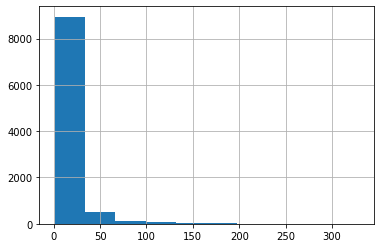

In [35]:
movie_ratingCount['totalRatingCount'].hist(bins = 10)

In [47]:
popularity_threshold = 50
rating_popular_movie= rating_with_totalRatingCount.query('totalRatingCount >= @popularity_threshold')

In [48]:
movie_features_df=rating_popular_movie.pivot_table(index='title',columns='userId',values='rating').fillna(0)

In [40]:
from scipy.sparse import csr_matrix

movie_features_df_matrix = csr_matrix(movie_features_df.values)

from sklearn.neighbors import NearestNeighbors


model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(movie_features_df_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [41]:
query_index = np.random.choice(movie_features_df.shape[0])
distances, indices = model_knn.kneighbors(movie_features_df.iloc[query_index,:].values.reshape(1, -1), n_neighbors = 6)

In [42]:
for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(movie_features_df.index[query_index]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, movie_features_df.index[indices.flatten()[i]], distances.flatten()[i]))

Recommendations for Star Trek: First Contact (1996):

1: Star Trek II: The Wrath of Khan (1982), with distance of 0.4034106135368347:
2: Independence Day (a.k.a. ID4) (1996), with distance of 0.5111082792282104:
3: Star Trek: Generations (1994), with distance of 0.513648271560669:
4: Star Wars: Episode IV - A New Hope (1977), with distance of 0.5356337428092957:
5: Star Wars: Episode VI - Return of the Jedi (1983), with distance of 0.5429878234863281:
